In [17]:
import pandas as pd
import glob
import random
import os

from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
from networkx.algorithms.bipartite.basic import color
from numpy.random import seed
import numpy as np
from tensorflow.random import set_seed
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')

In [3]:
img_size = 256
batch_size = 64
seed = 42


In [8]:
#main_path = "../input/chest-xray-pneumonia/chest_xray/"
main_path = "../chest_xray/"


train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [12]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = train_list.copy()

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = test_list.copy()

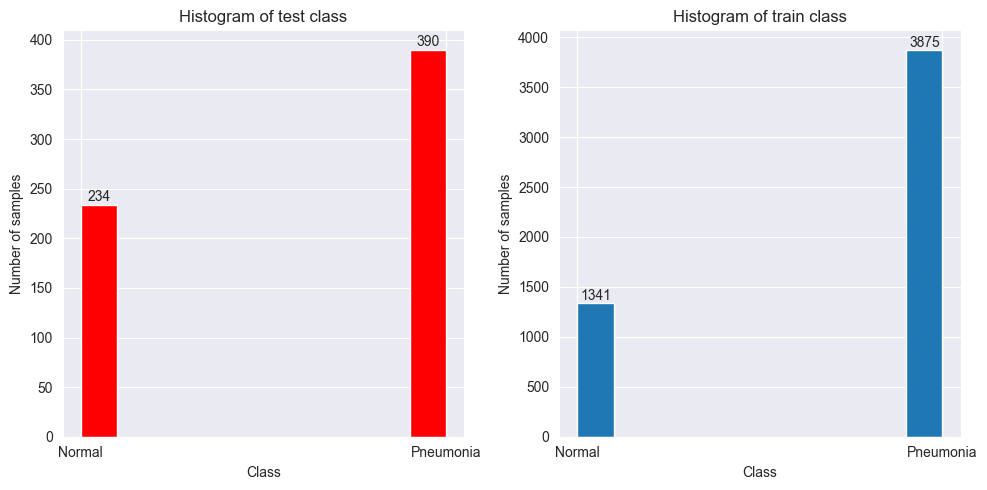

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
n_1, bins_1, patches_1 = axes[0].hist(df_test['class'],color='red')
axes[0].set_title('Histogram of test class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of samples')
for i in range(len(n_1)):
    if n_1[i] > 0:
        axes[0].text(bins_1[i] + (bins_1[i+1] - bins_1[i])/2, n_1[i]+0.5, str(int(n_1[i])), ha='center', va='bottom')

n_2, bins_2, patches_2 = axes[1].hist(df_train['class'])
axes[1].set_title('Histogram of train class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of samples')
for i in range(len(n_2)):
    if n_2[i] > 0:
        axes[1].text(bins_2[i] + (bins_2[i+1] - bins_2[i])/2, n_2[i]+0.5, str(int(n_2[i])), ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [35]:
import cv2
image = cv2.imread(test_normal[0], cv2.IMREAD_UNCHANGED)
print(image.shape)
if len(image.shape) :
  print("eriicaaaaa")

(1317, 1857)
eriic
